# Settings

In [1]:
EXP_NO = 47
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [2]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

# Library

In [3]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV, RidgeClassifierCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearnex import patch_sklearn

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from features import extract_representative_color_features, extract_representative_colors
from dataset import load_csvfiles, load_photofile
from folder import experiment_dir_of
from target import soring_date2target

In [4]:
pd.options.display.float_format = '{:.5f}'.format

In [5]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Prepare directory

In [6]:
output_dir = experiment_dir_of(EXP_NO)

In [7]:
output_dir

'..\\scripts\\..\\experiments\\exp047'

# Prepare logger

In [8]:
logger = getLogger(__name__)

In [9]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [10]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-22 16:35:34,652 - __main__ - INFO - Experiment no: 47
2021-07-22 16:35:34,654 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-22 16:35:34,655 - __main__ - INFO - SEED: 1
2021-07-22 16:35:34,655 - __main__ - INFO - REGRESSION: True


# Load submission

In [11]:
submission = pd.read_csv(os.path.join('exp035', '035_submission.csv'))
submission

,target
0,1.22103
1,2.52170
2,1.82251
3,2.23864
4,0.57689
...,...
5914,1.79914
5915,0.96312
5916,1.72539
5917,1.95114


In [12]:
@np.vectorize
def round_prediction(value):
    if value < 0.05:
        return 0
    elif 0.95 < value < 1.05:
        return 1
    elif 1.95 < value < 2.05:
        return 2
    elif 2.95 < value:
        return 3
    else:
        return value

In [13]:
test = pd.DataFrame()
test['target'] = round_prediction(submission['target'])
test

,target
0,1.22103
1,2.52170
2,1.82251
3,2.23864
4,0.57689
...,...
5914,1.79914
5915,1.00000
5916,1.72539
5917,2.00000


In [14]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-22 16:35:34,727 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp047\047_submission.csv


2021-07-22 16:35:34,834 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp047\prediction.png


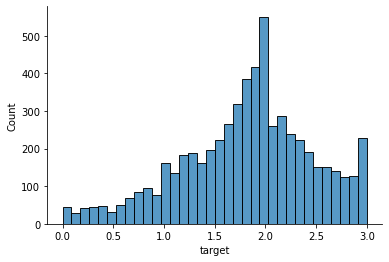

In [15]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))